## MULTI DAPI VAE in PYRO

### IMPORT NECESSARY MODULES

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as mp

from LOW_LEVEL_UTILITIES.utilities import show_batch, save_model, save_obj, load_model, load_obj, get_model_dictionary
from LOW_LEVEL_UTILITIES.utilities import dataset_in_memory, check_datasets
from simulation_dictionary import SimulationDictionary 
#from VAE.vae_model import VAE

import numpy as np
import os
import torch
import torchvision
import torchvision.transforms as tvt
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceGraph_ELBO, TraceEnum_ELBO, config_enumerate #, JitTraceEnum_ELBO, 
from pyro.optim import Adam, Adamax, SGD

def test_model(model, guide, loss):
    pyro.clear_param_store()
    loss.loss(model, guide)

## Generate simulation parameters

In [13]:
#### Create the simulation parameters dictionary

params=SimulationDictionary()
#write_dir = "/home/ldalessi/spacetx-research/parallel_enum_annealing_v2/ARCHIVE/"
#params=load_obj(write_dir,"params_disk_v1")
params['UNET.N_prediction_maps']=1
print(params)
params.check_consistency()

{'SD.width': 20, 'SD.dim_h1': 200, 'SD.dim_h2': -1, 'ZWHAT.dim': 50, 'ZMASK.dim': 50, 'ANNEALING.protocol': 'Linear_Decay', 'ANNEALING.prob_initial': 1.0, 'ANNEALING.prob_final': 1e-05, 'ANNEALING.begin': 100, 'ANNEALING.duration': 200, 'PRIOR.n_max_objects': 6, 'PRIOR.min_object_size': 15, 'PRIOR.max_object_size': 35, 'PRIOR.expected_object_size': 20, 'IMG.size_raw_image': 80, 'IMG.ch_in_description': ['DAPI'], 'UNET.N_max_pool': 4, 'UNET.N_up_conv': 2, 'UNET.CH_after_first_two_conv': 32, 'UNET.N_prediction_maps': 1, 'NMS.p_threshold': 0.0, 'NMS.overlap_threshold': 0.2, 'use_cuda': True}


### Instantiate Inference 

In [14]:
##from VAE.vae_parts import Inference
##import collections
##
##inference=Inference(params)
###
##imgs_in = torch.rand((2, len(params['IMG.ch_in_description']),params["IMG.size_raw_image"],params["IMG.size_raw_image"]))
###z_predictions = inference.unet.forward(random_images,True)
##
##                                                               
##raw_width,raw_height = imgs_in.shape[-2:]
##
### FEATURES EXTRACTION VIA A UNET
##features = inference.unet.forward(imgs_in)
##
### TRANSFROM THE FEATURES INTO z_where predictions
##z_where_all = inference.roi.forward(features,raw_width,raw_height)
##print(z_where_all.prob.shape)
##
### PERFORM Non-Max-Suppression    
##z_where = inference.nms.forward(z_where_all) 
##
### CROP
##cropped_imgs = inference.cropper.forward(z_where,imgs_in)
##
### ENCODE
##z_what = inference.encoder_zwhat.forward(cropped_imgs)
##z_mask = inference.encoder_zmask.forward(cropped_imgs)
##
##print(z_where.prob.shape)
##print(z_what.z_mu.shape)
##print(z_mask.z_mu.shape)
##
##z_predictions = collections.namedtuple('z_prediction', 'z_where z_mask z_what')._make(    [z_where, z_mask, z_what])
##             
##z_predictions = inference.forward(imgs_in)
##                
##print("ch_list=",inference.unet.ch_list)
##print(z_predictions.z_where.prob.shape)
##print(z_predictions.z_where.bx_dimfull.shape)

### Debug inference 

In [15]:
#random_images = torch.rand((2, len(params['IMG.ch_in_description']),params["IMG.size_raw_image"],params["IMG.size_raw_image"]))
#z_nms = inference(random_images)
#print(z_nms.z_where.prob.shape)
#print(z_nms.z_mask.z_mu.shape)
#print(z_nms.z_what.z_mu.shape)
#
#
## Trick to find where the in_place operation is
#with torch.autograd.set_detect_anomaly(True):
#    print("-------")
#    inference.unet.describe_receptive_field(random_images)
#    print("-------")
#    imgs_with_grid = inference.unet.show_grid(random_images)
#    print("imgs_with_grid.shape",imgs_with_grid.shape)
#    imgs_to_print = imgs_with_grid[0,:,:1,:,:]
#    print("imgs_to_print.shape ",imgs_to_print.shape)
#    show_batch(imgs_to_print)
#    
#    #---------------------------------------------#
#    # check that I can propagate through the INFERENCE netwrok
#    #---------------------------------------------#
#    z_nms = inference.forward(random_images)
#
#    target = torch.zeros_like(z_nms.z_where.prob)
#    criterium = torch.nn.MSELoss()
#    loss = criterium(z_nms.z_where.prob, target)
#    loss.backward()

### Instantiate Generator 

In [16]:
#from VAE.vae_parts import Masks_Generator, Imgs_Generator
#mask_generator=Masks_Generator(params)
#imgs_generator=Imgs_Generator(params)

### Debug generator 

In [17]:
#imgs  = imgs_generator.forward(z_nms.z_where,z_nms.z_what.z_mu,
#                               params["IMG.size_raw_image"],params["IMG.size_raw_image"])

#masks = mask_generator.forward(z_nms.z_where,z_nms.z_mask.z_mu,
#                               params["IMG.size_raw_image"],params["IMG.size_raw_image"])

#print(imgs.shape)
#print(masks.shape)

#show_batch(imgs.view(-1,1,80,80))

In [18]:
#show_batch(masks.view(-1,1,80,80))

In [19]:
#print("masks.shape",masks.shape)
#print(torch.max(masks))
#print(torch.min(masks))
#show_batch(masks.view(-1,1,80,80)[:2])

In [20]:
#dist.Beta(5.0,2.0).log_prob(v)

## Instantiate the Compositional_VAE

In [23]:
# %load VAE/vae_model.py
import numpy as np
import torch
import pyro
import pyro.distributions as dist
from PIL import Image, ImageDraw
from LOW_LEVEL_UTILITIES.distributions import UniformWithTails, Indicator, NullScoreDistribution_Bernoulli, UnitCauchy
from VAE.vae_parts import Inference,Imgs_Generator,Masks_Generator
import matplotlib.pyplot as plt

import collections
from torch.distributions import constraints
import pyro.poutine as poutine



class Compositional_VAE(torch.nn.Module):
    
    def __init__(self, params):
        super().__init__()
        
        # Instantiate the encoder and decoder
        self.inference = Inference(params)
        self.generator_imgs  = Imgs_Generator(params)
        self.generator_masks = Masks_Generator(params)
        
        
        
        #-------------------------#
        #--- Global Parameters ---#
        #-------------------------#
        self.Zwhat_dim         = params['ZWHAT.dim']
        self.Zmask_dim         = params['ZMASK.dim']
        self.size_raw_image    = params['IMG.size_raw_image'] 
        self.ch_in_description = params['IMG.ch_in_description'] 
        self.ch_raw_image      = len(self.ch_in_description) 
        
        #--------------------------------#
        #--- Pramatres Regolurization ---#
        #--------------------------------#
        self.lambda_box_size = getattr(params,'REGULARIZATION.lambda_box_size',0.0)
        self.lambda_tot_var  = getattr(params,'REGULARIZATION.lambda_tot_var',0.0)
        self.lambda_overlap  = getattr(params,'REGULARIZATION.lambda_overlap',0.0)
        self.LOSS_ZWHERE = getattr(params,'REGULARIZATION.LOSS_ZWHERE',0.0) 
        self.LOSS_ZMASK = getattr(params,'REGULARIZATION.LOSS_ZMASK',0.1)
        self.LOSS_ZWHAT = getattr(params,'REGULARIZATION.LOSS_ZWHAT',1.0)
        
               
        #------------------------------------#
        #----------- PRIORS -----------------#
        #------------------------------------#
        self.n_max_objects = params['PRIOR.n_max_objects'] 
        self.min_size      = params['PRIOR.min_object_size'] 
        self.max_size      = params['PRIOR.max_object_size'] 
        self.expected_size = params['PRIOR.expected_object_size'] 
        
        # Size of a object is uniform with tails between min_object_size and max_object_size  
        self.tails_dist_size = 0.1*self.expected_size 
        
        # Location of the BoundingBox centers is uniform in (-1,1) WITH exponential tails
        self.tails_dist_center = 0.1*self.expected_size 
        
        # Put everything on the cude if necessary
        self.use_cuda = params["use_cuda"]
        self.device = 'cuda' if self.use_cuda else 'cpu'
        if self.use_cuda:
            self.cuda()
            
    def annealing_prob_object(self,t):
        if(t is None):
            return 0.5*(self.ANN_initial+self.ANN_final)
        if(self.ANN_protocol == "Flat"):
            return 0.5*(self.ANN_initial+self.ANN_final)*np.ones_like(t)
        elif(self.ANN_protocol == "Linear_Decay"):
            x = (self.ANN_final - self.ANN_initial) * (t - self.ANN_begin) / self.ANN_duration + self.ANN_initial
            return np.clip(x, min(self.ANN_initial,self.ANN_final), max(self.ANN_initial,self.ANN_final))
        elif(self.ANN_protocol == "Exponential_Decay"):
            decay_rate = np.log(self.ANN_initial / self.ANN_final) / self.ANN_duration
            x = self.ANN_initial * np.exp(-decay_rate * (t - self.ANN_begin))
            return np.clip(x, min(self.ANN_initial,self.ANN_final), max(self.ANN_initial,self.ANN_final))
        else:
            raise Exception ('Annealing Protocoll is invalid')
        
    def mask_argmin_argmax(self,w,label=None):   
        """ Return the mask with one 1 along the direction dim=-4 where the value of w is either max or min
            This is usefull to find the object a pixel belongs to 
        """
        with torch.no_grad():
            assert len(w.shape) == 5 #batch_size,n_box,1,width,height = w.shape
            k = w.shape[-4]
            
            if(label == "argmax"):
                real_indeces = torch.argmax(w,dim=-4,keepdim=True) #max over boxes dimension
            elif(label == "argmin"):
                real_indeces = torch.argmin(w,dim=-4,keepdim=True) #min over boxes dimension
            else:
                raise Exception('invalid label is neither argmin nor argmax. Label = {}'.format(label))
                
            fake_indeces = torch.arange(start=0, end=k, step=1).view(1,-1,1,1,1).to(real_indeces.device)
            mask = (real_indeces == fake_indeces).float()
            return mask
        

    def show_priors(self):
        #raise NotImplementedError
        one  = torch.tensor([1.0])
        if(self.use_cuda):
            # put these two TENSORS on the GPU
            # Note that scalar times tensor is a tensor with the same device
            one=one.cuda()

        zero = 0.0*one             
        cdf = torch.arange(0,1.0,0.01).to(one.device)             
            
        # z_what    
        dist_z_what = dist.Normal(zero,one)
        z_what_x = dist_z_what.icdf(cdf)
        z_what_y = torch.exp(dist_z_what.log_prob(z_what_x))  
        
        # z_mask
        dist_z_mask = dist.Normal(zero,one)
        z_mask_x = dist_z_mask.icdf(cdf)
        z_mask_y = torch.exp(dist_z_mask.log_prob(z_mask_x))
        
        # size of boxes
        dist_bw_bh = UniformWithTails(self.min_size*one,self.max_size,self.tails_dist_size)
        bw_bh_x = dist_bw_bh.icdf(cdf)
        bw_bh_y = torch.exp(dist_bw_bh.log_prob(bw_bh_x))  
        
        # location of boxes
        dist_bx_by = UniformWithTails(zero,self.size_raw_image,self.tails_dist_center)
        bx_by_x = dist_bx_by.icdf(cdf)
        bx_by_y = torch.exp(dist_bx_by.log_prob(bx_by_x))  
        
        # foreground pixels
        fg_mu = pyro.param("fg_mu").clone().detach()
        sigma = pyro.param("fg_sigma").clone().detach()
        dist_fg_pixel = dist.Normal(fg_mu,sigma)
        fg_pixel_x = torch.arange(0,1.0,0.01).to(one.device) 
        fg_pixel_y = torch.exp(dist_fg_pixel.log_prob(fg_pixel_x))
        
        # background pixels
        bg_mu = pyro.param("bg_mu").clone().detach()
        sigma = pyro.param("bg_sigma").clone().detach()
        dist_bg_pixel = dist.Normal(bg_mu,sigma)
        bg_pixel_x = torch.arange(0,1.0,0.01).to(one.device) 
        bg_pixel_y = torch.exp(dist_bg_pixel.log_prob(bg_pixel_x))
        
        # overlap of masks
        dist_overlap = dist.Exponential(rate=self.exp_scale_reg_overlap*one)
        overlap_x = torch.arange(0,1.0,0.01).to(one.device) 
        overlap_y = torch.exp(dist_overlap.log_prob(overlap_x))
        
        # annealing protocol          
        epoch_max = 1.2*( self.ANN_duration + self.ANN_begin)
        annealing_x_np = np.arange(start=0, stop=epoch_max, step=1)
        annealing_y_np = self.annealing_prob_object(annealing_x_np)
        
        
        
        # Create a plot with the priors
        fontsize=20
        labelsize=20
        fig, axs = plt.subplots(4, 2, figsize=(15,15))
        
        axs[0,0].set_xlabel('z_what [dimless]',fontsize=fontsize)
        #axs[0,0].set_title('Normal',fontsize=fontsize)
        axs[0,0].tick_params(axis='both', which='major', labelsize=labelsize)
        axs[0,0].plot(z_what_x.cpu().numpy(),z_what_y.cpu().numpy())
        
        axs[0,1].set_xlabel('z_mask [dimless]',fontsize=fontsize)
        #axs[0,1].set_title('Normal',fontsize=fontsize)
        axs[0,1].tick_params(axis='both', which='major', labelsize=labelsize)
        axs[0,1].plot(z_mask_x.cpu().numpy(),z_mask_y.cpu().numpy())
        
        
        axs[1,0].set_xlabel('location bounding_box [pixels]',fontsize=fontsize)
        #axs[1,0].set_title('UniformWithTails',fontsize=fontsize)
        axs[1,0].tick_params(axis='both', which='major', labelsize=labelsize)
        axs[1,0].plot(bx_by_x.cpu().numpy(),bx_by_y.cpu().numpy())
        
        axs[1,1].set_xlabel('size bounding box [pixels]',fontsize=fontsize)
        #axs[1,1].set_title('UniformWithTails',fontsize=fontsize)
        axs[1,1].tick_params(axis='both', which='major', labelsize=labelsize)
        axs[1,1].plot(bw_bh_x.cpu().numpy(),bw_bh_y.cpu().numpy())
        
        axs[2,0].set_xlabel('Intensity fg pixels',fontsize=fontsize)
        #axs[2,0].set_title('Normal',fontsize=fontsize)
        axs[2,0].tick_params(axis='both', which='major', labelsize=labelsize)
        axs[2,0].plot(fg_pixel_x.cpu().numpy(),fg_pixel_y.cpu().numpy())
        
        axs[2,1].set_xlabel('Intensity bg pixels',fontsize=fontsize)
        #axs[2,1].set_title('Normal',fontsize=fontsize)
        axs[2,1].tick_params(axis='both', which='major', labelsize=labelsize)
        axs[2,1].plot(bg_pixel_x.cpu().numpy(),bg_pixel_y.cpu().numpy())  

        axs[3,0].set_xlabel('Overlap of masks',fontsize=fontsize)
        #axs[3,0].set_title('Exponential',fontsize=fontsize)
        axs[3,0].tick_params(axis='both', which='major', labelsize=labelsize)
        axs[3,0].plot(overlap_x.cpu().numpy(),overlap_y.cpu().numpy())
        
        axs[3,1].set_xlabel('Annealing Protocoll(epoch)',fontsize=fontsize)
        #axs[3,1].set_title('Annealing Protocoll',fontsize=fontsize)
        axs[3,1].tick_params(axis='both', which='major', labelsize=labelsize)
        axs[3,1].plot(annealing_x_np,annealing_y_np)
        
        plt.subplots_adjust(wspace=0.4, hspace=0.3)   
    
   
    def score_observations(self,box_dimfull,putative_imgs,putative_masks,
                           mask_pixel_assignment,definitely_bg_mask,imgs):   
        
        # get the parameters 
        normal_sigma = pyro.param("normal_sigma")
        bg_mu = pyro.param("bg_mu")
        fg_mu = pyro.param("fg_mu")
        bg_sigma = pyro.param("bg_sigma")
        fg_sigma = pyro.param("fg_sigma")
        
        # The foreground/background should be drawn from a Cauchy distribtion with scalar parameters 
        # TO IMPROVE: parameter should be different for each channel
        obs_imgs = imgs.unsqueeze(-4) # also add a singleton for the n_object dimension
        log_p_definitely_bg_cauchy = UnitCauchy(bg_mu,bg_sigma).expand(obs_imgs.shape).mask(definitely_bg_mask).log_prob(obs_imgs)
        obs_imgs = obs_imgs.expand(-1,self.n_max_objects,-1,-1,-1) # expand for dimension over n_boxes
        log_p_given_bg_cauchy = UnitCauchy(bg_mu,bg_sigma).expand(obs_imgs.shape).mask(mask_pixel_assignment).log_prob(obs_imgs)
        log_p_given_fg_cauchy = UnitCauchy(fg_mu,fg_sigma).expand(obs_imgs.shape).mask(mask_pixel_assignment).log_prob(obs_imgs)
        log_p_given_fg_normal = dist.Normal(putative_imgs,normal_sigma).mask(mask_pixel_assignment).log_prob(obs_imgs)   
                    
        # technically incorrect but it speeds up training and lead to binarized masks
        # The probability of each pixel value is:
        # P(x) = w * P(x|FG) + (1-w) * P(x|BG)
        log_partial_pixel_cauchy = putative_masks*log_p_given_fg_cauchy+(1.0-putative_masks)*log_p_given_bg_cauchy 
        log_partial_pixel_normal = putative_masks*log_p_given_fg_normal+(1.0-putative_masks)*log_p_given_bg_cauchy 
                        
        # compute logp
        logp_definitely_bg = torch.sum(log_p_definitely_bg_cauchy,dim=(-1,-2,-3)) 
        logp_box_off       = torch.sum(log_p_given_bg_cauchy,dim=(-1,-2,-3))
        logp_box_on_cauchy = torch.sum(log_partial_pixel_cauchy,dim=(-1,-2,-3))
        logp_box_on_normal = torch.sum(log_partial_pixel_normal,dim=(-1,-2,-3))  
        
        # package the logp
        common_logp    = logp_definitely_bg/self.n_max_objects
        log_probs = collections.namedtuple('logp', 'logp_off, logp_on_cauchy, logp_on_normal')._make(
                [common_logp+logp_box_off, common_logp + logp_box_on_cauchy, common_logp + logp_box_on_normal])           
        
        
        # compute the regularizations
         #- reg1: bounding box should be as small as possible --#
        #- Note that volume_mask is detached from computation graph, 
        #- therefore this regolarization can only make box_volume smaller 
        #- not make the mask_volume larger.
        volume_box  = (box_dimfull.bw_dimfull*box_dimfull.bh_dimfull).squeeze(-1)
        with torch.no_grad():
            volume_mask    = torch.sum(mask_pixel_assignment*(putative_masks>0.5).float(),dim=(-1,-2,-3))
            volume_box_min = torch.tensor(self.min_size*self.min_size, device=volume_mask.device, dtype=volume_mask.dtype)
            volume_min     = torch.max(volume_mask,volume_box_min)
        reg_box_size   = (volume_box/volume_min - 1.0)**2
            
        #- reg 2: mask should have small total variations -#
        #- TotVar = integral of the absolute gradient -----#
        #- This is L1 b/c we want discountinuity ----------#
        pixel_weights = putative_masks*mask_pixel_assignment
        grad_x = torch.sum(torch.abs(pixel_weights[:,:,:,:,:-1] - pixel_weights[:,:,:,:,1:]),dim=(-1,-2,-3))
        grad_y = torch.sum(torch.abs(pixel_weights[:,:,:,:-1,:] - pixel_weights[:,:,:,1:,:]),dim=(-1,-2,-3))
        reg_tot_var_mask = (grad_x+grad_y)
                             
        #- reg 3: mask should have small or no overlap ---------------#
        #- Question: Assign the cost to the second most likely mask? -#
        values, indeces = torch.topk(putative_masks, k=2, dim=1, largest=True) # shape: batch x 2 x 1 x width x height
        prod = torch.prod(values,dim=1,keepdim=True) # shape batch x 1 x 1 x width x height
        with torch.no_grad():
            fake_indeces = torch.arange(self.n_max_objects).view(1,-1,1,1,1).to(indeces.device)
            assignment_mask = (indeces[:,-1:,:,:,:] == fake_indeces).float()
        reg_overlap_mask = torch.sum(prod*assignment_mask,dim=(-1,-2,-3))**2
            
        regularizations = collections.namedtuple('reg', "box_size tot_var_mask overlap_mask")._make(
            [reg_box_size, reg_tot_var_mask, reg_overlap_mask])


        return log_probs,regularizations
    
    
    
    
    
    def guide(self, imgs=None, epoch=None):
        
        """ The GUIDE takes a mini-batch of images and: 
            1. run the inference to get: zwhere,zwhat
            2. sample:
                - z ~ N(z_mu, z_std) where each component of z is drawn independently
                - c ~ Bernulli(p)
                - cxcy ~ N(cxcy_mu,0.1) 
                - dxdy ~ gamma(dxdy_mu,0.1) 
        """
        
        #-----------------------#
        #--------  Trick -------#
        #-----------------------#
        if(imgs is None):
            imgs = torch.zeros(8,self.ch_raw_image,self.size_raw_image,self.size_raw_image)
            if(self.use_cuda):
                imgs=imgs.cuda()
        assert(len(imgs.shape)==4)
        batch_size,ch,width,height = imgs.shape    
        assert(width == height) 
        one = imgs.new_ones(1)
        #-----------------------#
        #----- Enf of Trick ----#
        #-----------------------#
        
        # register the modules
        pyro.module("inference",self.inference)
        
        #register the oparameters
        std_bx_dimfull = pyro.param("std_bx_dimfull", one, constraint=constraints.positive)
        std_by_dimfull = pyro.param("std_by_dimfull", one, constraint=constraints.positive)
        std_bw_dimfull = pyro.param("std_bw_dimfull", one, constraint=constraints.positive)
        std_bh_dimfull = pyro.param("std_bh_dimfull", one, constraint=constraints.positive)

        with pyro.plate("batch", batch_size, dim =-2 ):
            
            #--------------------------#
            #-- 1. run the inference --#
            #--------------------------#          
            z_nms = self.inference.forward(imgs)

            with pyro.plate("n_objects", self.n_max_objects, dim =-1 ):
                     
                #---------------#    
                #-- 2. Sample --#
                #---------------#
                   
                # Z_WHAT
                pyro.sample("z_what",dist.Normal(z_nms.z_what.z_mu, z_nms.z_what.z_std).to_event(1))
                                
                # Z_MASK
                pyro.sample("z_mask",dist.Normal(z_nms.z_mask.z_mu, z_nms.z_mask.z_std).to_event(1)) 

                # Z_WHERE

                # Location of bounding box
                pyro.sample("bx_dimfull",dist.Normal(z_nms.z_where.bx_dimfull, std_bx_dimfull).to_event(1))
                pyro.sample("by_dimfull",dist.Normal(z_nms.z_where.by_dimfull, std_by_dimfull).to_event(1))
                
                # Size of Bounding Box 
                pyro.sample("bw_dimfull",dist.Normal(z_nms.z_where.bw_dimfull, std_bw_dimfull).to_event(1)) 
                pyro.sample("bh_dimfull",dist.Normal(z_nms.z_where.bh_dimfull, std_bh_dimfull).to_event(1))
                
                # Prob of an object 
                p = z_nms.z_where.prob.squeeze(-1)
                c = pyro.sample("prob_object",dist.Bernoulli(probs = p))                    
                
                

    def model(self, imgs=None, epoch=None):
        """ The MODEL takes a mini-batch of images and:
            1.  sample the latent from the prior:
                - z ~ N(0,1)
                - presence of a cell ~ Bernulli(p)
                - cxcy ~ uniform (-1,+1)
                - dxdy ~ gamma(alpha,beta) 
            2.  runs the generative model
            3A. If imgs = None then
                score the generative model against actual data 
                (it requires a noise model and fix the reconstruction loss)
            3B. Else
                return the generated image
                
            This is a trick so that by passing imgs=None I can:
            1. effectively test the priors
            2. debug shapes by using poutine.trace
        """
        #-----------------------#
        #--------  Trick -------#
        #-----------------------#
        if(imgs is None):
            observed = False
            imgs = torch.zeros(8,self.ch_raw_image,self.size_raw_image,self.size_raw_image)
            if(self.use_cuda):
                imgs=imgs.cuda()
        else:
            observed = True
        assert(len(imgs.shape)==4)
        batch_size,ch,width,height = imgs.shape    
        assert(width == height) 
        zero = imgs.new_zeros(1)
        one = imgs.new_ones(1)
        #-----------------------#
        #----- Enf of Trick ----#
        #-----------------------#
        
        # register the modules 
        pyro.module("generator_imgs",  self.generator_imgs)
        pyro.module("generator_masks", self.generator_masks)

        # register the parameters of the distribution used to score the results
        normal_sigma = pyro.param("normal_sigma", one, constraint=constraints.positive)   
        bg_mu        = pyro.param("bg_mu", 0.1*one, constraint=constraints.unit_interval)
        bg_sigma     = pyro.param("bg_sigma", 0.1*one, constraint=constraints.interval(0.01,0.25))
        fg_mu        = pyro.param("fg_mu", 0.9*one, constraint=constraints.unit_interval)
        fg_sigma     = pyro.param("fg_sigma", 0.1*one, constraint=constraints.interval(0.01,0.25))
        
                
        with pyro.plate("batch", batch_size, dim=-2):
            
            with pyro.plate("n_objects", self.n_max_objects, dim =-1):
            
                #------------------------#
                # 1. Sample from priors -#
                #------------------------#
                
                # 1. Probability of a box being active
                c = pyro.sample("prob_object",NullScoreDistribution_Bernoulli()).to(one.device)
                c_mask = (c != 0)  # convert FloatTensor -> ByteTensor
                
                with poutine.mask(mask=c_mask):
                
                    #- Z_WHAT, Z_WHERE 
                    z_what = pyro.sample("z_what",dist.Normal(zero,one).expand([self.Zwhat_dim]).to_event(1))    
                    z_mask = pyro.sample("z_mask",dist.Normal(zero,one).expand([self.Zmask_dim]).to_event(1)) 
                                   
                    #= Location of bounding box
                    bx_dimfull = pyro.sample("bx_dimfull",UniformWithTails(zero,width,self.tails_dist_center).expand([1]).to_event(1))
                    by_dimfull = pyro.sample("by_dimfull",UniformWithTails(zero,width,self.tails_dist_center).expand([1]).to_event(1))
                
                    #- Size of bounding box
                    bw_dimfull = pyro.sample("bw_dimfull",UniformWithTails(self.min_size*one,self.max_size,self.tails_dist_size).expand([1]).to_event(1))
                    bh_dimfull = pyro.sample("bh_dimfull",UniformWithTails(self.min_size*one,self.max_size,self.tails_dist_size).expand([1]).to_event(1))
        
                #------------------------------#
                # 2. Run the generative model -#
                #------------------------------#
                box_dimfull = collections.namedtuple('box_dimfull', 'bx_dimfull by_dimfull bw_dimfull bh_dimfull')._make(
                                                    [bx_dimfull,by_dimfull,bw_dimfull,bh_dimfull])
                
                putative_imgs  = self.generator_imgs.forward(box_dimfull,z_what,width,height) 
                putative_masks = self.generator_masks.forward(box_dimfull,z_mask,width,height)
                
                # Resolve the conflict. Each pixel belongs to only one FG object
                # If a pixel does not belong to any object it belongs to the background
                mask_pixel_assignment = self.mask_argmin_argmax(putative_masks,"argmax") 
                #mask_pixel_assignment = self.mask_argmin_argmax(putative_masks*p_inferred[...,None,None,None],"argmax") 
                definitely_bg_mask = (torch.sum(mask_pixel_assignment,dim=-4,keepdim=True) == 0.0) 
                
                # sample the background 
                background_sample = UnitCauchy(bg_mu,bg_sigma).expand(imgs.shape).sample()

                    
                if(observed):
                    logp,reg = self.score_observations(box_dimfull,putative_imgs,putative_masks,
                                                       mask_pixel_assignment,definitely_bg_mask,imgs)
                    total_reg = getattr(self,'lambda_box_size',0.0)*reg.box_size + \
                                getattr(self,'lambda_tot_var',0.0)*reg.tot_var_mask + \
                                getattr(self,'lambda_overlap',0.0)*reg.overlap_mask
                            
                    log_prob_ZMASK = getattr(self,'LOSS_ZMASK',0.0)*torch.stack((logp.logp_off,logp.logp_on_cauchy-total_reg),dim=-1) 
                    log_prob_ZWHAT = getattr(self,'LOSS_ZWHAT',0.0)*torch.stack((logp.logp_off,logp.logp_on_normal-total_reg),dim=-1) 

                    pyro.sample("LOSS_ZMASK", Indicator(log_probs=log_prob_ZMASK), obs = c)
                    pyro.sample("LOSS_ZWHAT", Indicator(log_probs=log_prob_ZWHAT), obs = c)
                    
                return putative_imgs,putative_masks,background_sample,c
    

    def reconstruct_img(self,original_image,bounding_box=False):
        if(self.use_cuda):
            original_image=original_image.cuda()
        
        batch_size,ch,width,height = original_image.shape
        assert(width==height)
        self.eval() # set the model into evaluation mode
        with torch.no_grad(): # do not keep track of the gradients
            
            #--------------------------#
            #-- 1. run the inference --#
            #--------------------------#        
            
            z_nms = self.inference.forward(original_image)
            p       = z_nms.z_where.prob         
            assert p.shape == (batch_size,self.n_max_objects,1)

            #--------------------------------#
            #--- 2. Run the model forward ---#
            #--------------------------------#
            putative_imgs  = self.generator_imgs.forward(z_nms.z_where,z_nms.z_what.z_mu,width,height) 
            putative_masks = self.generator_masks.forward(z_nms.z_where,z_nms.z_mask.z_mu,width,height)                
            mask_pixel_assignment = self.mask_argmin_argmax(putative_masks,"argmax")   
            definitely_bg_mask = (torch.sum(mask_pixel_assignment,dim=-4,keepdim=True) == 0.0) 
            
            #---------------------------------#
            #--- 3. Score the model ----------#
            #---------------------------------#
            logp,reg = self.score_observations(z_nms.z_where,putative_imgs,putative_masks,
                                               mask_pixel_assignment,definitely_bg_mask,original_image)
           
            #---------------------------------#
            #----- 4. Reconstruct images -----#
            #---------------------------------#
            box_is_active = (p>0.5).float()[...,None,None]
            fg_mask = (mask_pixel_assignment*putative_masks > 0.0).float()
            reconstructed_image = torch.sum(box_is_active*fg_mask*putative_imgs,dim=-4,keepdim=False)
            
            # 3. If bounding_box == True compute the bounding box
            if(bounding_box == False):
                return reconstructed_image,z_nms.z_where,putative_imgs,putative_masks,logp,reg
            elif(bounding_box == True):
                bounding_boxes = self.draw_batch_of_images_with_bb_only(z_nms.z_where,width,height)
                reconstructed_image_with_bb = bounding_boxes + reconstructed_image
                return reconstructed_image_with_bb,z_nms.z_where,putative_imgs,putative_masks,logp,reg
    
    def draw_batch_of_images_with_bb_only(self,z_where,width,height):
       
        # Exttract the probabilities for each box
        batch_size,n_boxes = z_where.prob.shape[:2]
        p = z_where.prob.view(batch_size,n_boxes,-1)
        
        # prepare the storage
        batch_bb_np    = np.zeros((batch_size,width,height,3)) # numpy storage for bounding box images
        
        # compute the coordinates of the bounding boxes and the probability of each box
        x1 = (z_where.bx_dimfull-0.5*z_where.bw_dimfull).view(batch_size,n_boxes,-1)
        x3 = (z_where.bx_dimfull+0.5*z_where.bw_dimfull).view(batch_size,n_boxes,-1)
        y1 = (z_where.by_dimfull-0.5*z_where.bh_dimfull).view(batch_size,n_boxes,-1)
        y3 = (z_where.by_dimfull+0.5*z_where.bh_dimfull).view(batch_size,n_boxes,-1)

        assert( len(x1.shape) == 3) 
        x1y1x3y3 = torch.cat((x1,y1,x3,y3),dim=2)
                
        # draw the bounding boxes
        for b in range(batch_size):
        
            # Draw on PIL
            img = Image.new('RGB', (width,height), color=0)
            draw = ImageDraw.Draw(img)
            for i in range(n_boxes):
                #if(p[b,i,0]>0.0):
                draw.rectangle(x1y1x3y3[b,i,:].cpu().numpy(), outline='red', fill=None)
            batch_bb_np[b,...] = np.array(img.getdata(),np.uint8).reshape(width,height,3)

        # Transform np to torch, rescale from [0,255] to (0,1) 
        batch_bb_torch = torch.from_numpy(batch_bb_np).permute(0,3,1,2).float()/255
        return batch_bb_torch.to(p.device)   
           
    def generate_synthetic_data(self, N=100):
        
        # prepare the storage 
        putative_imgs,putative_masks,background,c = self.model()
        assert putative_masks.shape[-2:] == background.shape[-2:] == putative_imgs.shape[-2:] # width, height are the same
        batch_size, n_boxes, ch, width, height = putative_imgs.shape
        synthetic_data = torch.zeros((N, ch, width, height), 
                                     dtype=torch.float32, 
                                     device='cpu', 
                                     requires_grad=False) 
            
        # loop to generate the images
        l = 0 
        while (l<N):         
            
            # generate the images and mask
            putative_imgs,putative_masks,background,c = self.model()
            box_is_active = (c == 1).float()[...,None,None,None] # add singleton for ch,width,height 
            imgs_prior = torch.sum((box_is_active*putative_imgs),dim=-4) + background
            
            # Compute left and right indeces
            r = min(l+batch_size,N)
            d = r-l           
            synthetic_data[l:r,:,:,:]=imgs_prior[0:d,:,:,:].detach().cpu()
            l = r
            
        return torch.clamp(synthetic_data,min=0.0, max=1.0)

In [24]:
vae = Compositional_VAE(params)

In [25]:
putative_imgs,putative_masks,background,c = vae.model()
print("putative_imgs.shape",putative_imgs.shape)
print("putative_masks.shape",putative_masks.shape)
print("background.shape",background.shape)
print("c.shape",c.shape)
print("max(putative_imgs)",torch.max(putative_imgs))
#print("max(log_p_given_bg)",torch.max(log_p_given_bg))

putative_imgs.shape torch.Size([8, 6, 1, 80, 80])
putative_masks.shape torch.Size([8, 6, 1, 80, 80])
background.shape torch.Size([8, 1, 80, 80])
c.shape torch.Size([8, 6])
max(putative_imgs) tensor(0.4366, device='cuda:0', grad_fn=<MaxBackward1>)


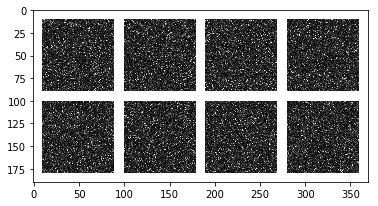

In [26]:
show_batch(background)

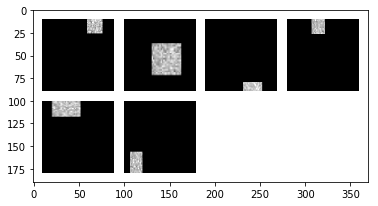

In [27]:
show_batch(putative_imgs[0])

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6842, device='cuda:0', grad_fn=<MaxBackward1>)


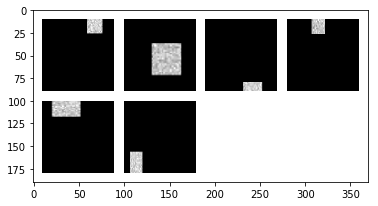

In [28]:
show_batch(putative_masks[0])
print(torch.min(putative_masks),torch.max(putative_masks))

In [29]:
#vae.show_priors()

### Debug model and guide

In [30]:
print("TEST SAMPLE")
test_model(vae.model, 
           vae.guide, TraceGraph_ELBO())

print("TEST PARALLEL ENUM")
test_model(vae.model, 
           config_enumerate(vae.guide, "parallel"), 
           TraceEnum_ELBO(max_plate_nesting=2))

TEST SAMPLE
TEST PARALLEL ENUM


### Check the prior

imgs_prior.shape torch.Size([20, 1, 80, 80])
type(imgs_prior) <class 'torch.Tensor'>
imgs_prior.device cpu
torch.max(imgs_prior) tensor(1.)
torch.min(imgs_prior) tensor(1.1921e-07)


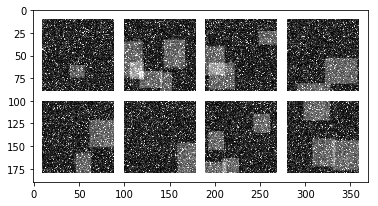

In [31]:
imgs_prior = vae.generate_synthetic_data(N=20)
show_batch(imgs_prior[:8,:1,:,:])

print("imgs_prior.shape",imgs_prior.shape)
print("type(imgs_prior)",type(imgs_prior))
print("imgs_prior.device",imgs_prior.device)
print("torch.max(imgs_prior)",torch.max(imgs_prior))
print("torch.min(imgs_prior)",torch.min(imgs_prior))

### Check the model with observation

In [32]:
putative_imgs,putative_masks,background,c = vae.model(imgs_prior.cuda())
#putative_imgs,pixel_weights,background,c = vae.model(imgs_prior)

print("putative_imgs.shape",putative_imgs.shape)
print("putative_masks.shape",putative_masks.shape)
print("background.shape",background.shape)
print("c.shape",c.shape)

putative_imgs.shape torch.Size([20, 6, 1, 80, 80])
putative_masks.shape torch.Size([20, 6, 1, 80, 80])
background.shape torch.Size([20, 1, 80, 80])
c.shape torch.Size([20, 6])


### Check the reconstruction

rec_img.shape torch.Size([20, 3, 80, 80])
min, max of rec_img) tensor(0., device='cuda:0') tensor(1.2889, device='cuda:0')
putative_imgs.shape torch.Size([20, 6, 1, 80, 80])
putative_masks.shape torch.Size([20, 6, 1, 80, 80])
logp.logp_off.shape torch.Size([20, 6])
logp.logp_on_cauchy.shape torch.Size([20, 6])
logp.logp_on_normal.shape torch.Size([20, 6])
reg.box_size.shape torch.Size([20, 6])
reg.overlap_mask.shape torch.Size([20, 6])
reg.tot_var_mask.shape torch.Size([20, 6])


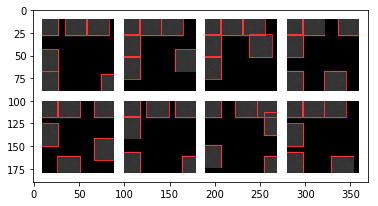

In [33]:
rec_img,z_where,putative_imgs,putative_masks,logp,reg = vae.reconstruct_img(imgs_prior,True)

print("rec_img.shape",rec_img.shape)
print("min, max of rec_img)",torch.min(rec_img),torch.max(rec_img))
print("putative_imgs.shape",putative_imgs.shape)
print("putative_masks.shape",putative_masks.shape)
print("logp.logp_off.shape",logp.logp_off.shape)
print("logp.logp_on_cauchy.shape",logp.logp_on_cauchy.shape)
print("logp.logp_on_normal.shape",logp.logp_on_normal.shape)
print("reg.box_size.shape",reg.box_size.shape)
print("reg.overlap_mask.shape",reg.overlap_mask.shape)
print("reg.tot_var_mask.shape",reg.tot_var_mask.shape)
#print(z_where)
show_batch(rec_img[:8,:,:,:])

#print(z_where.prob.shape)
#print(z_where.prob[1:2,:,0])
#print(z_where.bx_dimfull[1:2,:,0])
#print(z_where.by_dimfull[1:2,:,0])
#print(z_where.bw_dimfull[1:2,:,0])
#print(z_where.bh_dimfull[1:2,:,0])



### Load pretrained stuff if necessary

In [34]:
#--------------------------------#
#-- Get the current dictionary --#
#--------------------------------#
#current_dictionary=vae.state_dict()
#for k, v in current_dictionary.items():
#    print("CURRENT DICTIONARY",k)

#-----------------------------------#
#-- Get the pretrained dictionary --#
#-----------------------------------#
#archive_dir = '/home/ldalessi/spacetx-research/parallel_enum_annealing_v2/ARCHIVE/'
#pretrained_dict = get_model_dictionary(archive_dir,"vae_disk_v1_420")
#for k, v in pretrained_dict.items():
#    print("PRETRAINED DICTIONARY",k)

#-----------------------------------#
#-- Modify the current dictionary --#
#-----------------------------------#
#for k, v in pretrained_dict.items():
#    if(k in current_dictionary):
#        print("OVERLOADING ->",k)
#        current_dictionary[k]=v
# Reload the modified dictionary
#vae.load_state_dict(current_dictionary)

### Check the image reconstruction

In [35]:
#archive_dir="/home/ldalessi/spacetx-research/serious_training/ARCHIVE/"
#archive_dir="/Users/ldalessi/DAPI_unsupervised/spacetx-research/parallel_enum_of_patches/ARCHIVE/"
#load_model(vae,archive_dir,"compositional_vae_v10_1")
#imgs_rec,p,bxby_dimfull,bwbh_dimfull,cos_sin = vae.reconstruct_img(imgs_real[:8],True)
#show_batch(imgs_rec)
#print(p[0])
#print(bxby_dimfull[0])
#print(bwbh_dimfull[0])

In [36]:
#show_batch(imgs_real[:8])

## Generate (if necessary) and load the synthetic data

In [37]:
disk_data_dir = "/home/ldalessi/DATA/MULTI_DISK/"
real_data_dir = "/home/ldalessi/DATA/DAPI_ONLY_v3/"
mMNIST_data_dir = "/home/ldalessi/DATA/MULTI_MNIST/"

train_dataset = dataset_in_memory(disk_data_dir,"multi_disk_train_v1",use_cuda=params['use_cuda'])
test_dataset  = dataset_in_memory(disk_data_dir,"multi_disk_test_v1",use_cuda=params['use_cuda'])

#train_dataset = dataset_in_memory(disk_data_dir,"multi_disk_train_no_bg",use_cuda=params['use_cuda'])
#test_dataset  = dataset_in_memory(disk_data_dir,"multi_disk_test_no_bg",use_cuda=params['use_cuda'])

#train_dataset = dataset_in_memory(real_data_dir,"DAPI_dataset_train",use_cuda=params['use_cuda'])
#test_dataset  = dataset_in_memory(real_data_dir,"DAPI_dataset_test",use_cuda=params['use_cuda'])

#train_dataset = dataset_in_memory(mMNIST_data_dir,"multi_mnist_train_with_bg",use_cuda=params['use_cuda'])
#test_dataset  = dataset_in_memory(mMNIST_data_dir,"multi_mnist_test_with_bg",use_cuda=params['use_cuda'])

#train_dataset = dataset_in_memory(mMNIST_data_dir,"multi_mnist_train_no_bg",use_cuda=params['use_cuda'])
#test_dataset  = dataset_in_memory(mMNIST_data_dir,"multi_mnist_test_no_bg",use_cuda=params['use_cuda'])

## Check the train and test dataset

Dataset lenght: 2000
imgs.shape torch.Size([8, 1, 80, 80])
type(imgs) <class 'torch.Tensor'>
imgs.device cuda:0
torch.max(imgs) tensor(1., device='cuda:0')
torch.min(imgs) tensor(0., device='cuda:0')


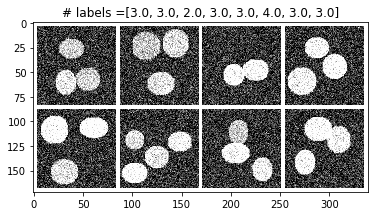

In [38]:
check_datasets(train_dataset)

Dataset lenght: 500
imgs.shape torch.Size([8, 1, 80, 80])
type(imgs) <class 'torch.Tensor'>
imgs.device cuda:0
torch.max(imgs) tensor(1., device='cuda:0')
torch.min(imgs) tensor(0., device='cuda:0')


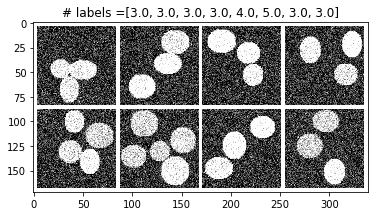

In [39]:
check_datasets(test_dataset)

500
torch.Size([500, 484])


array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ], dtype=float32)

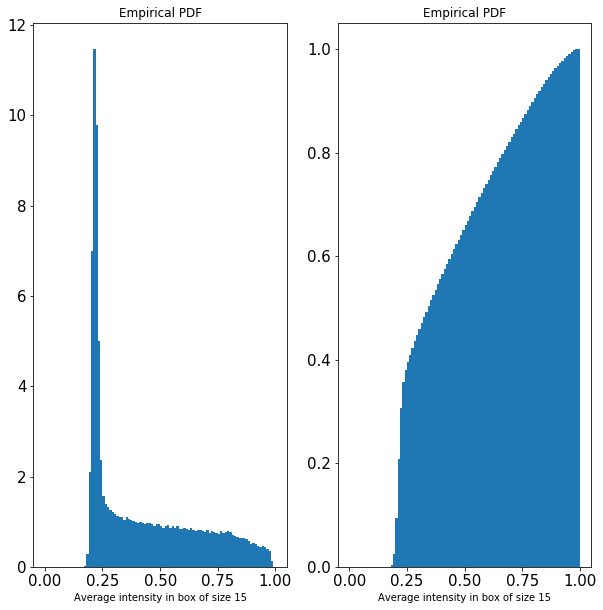

In [41]:
size=15
r = test_dataset.analyze_brightness_distribution(size=size,stride=3)
print(len(r))
print(r.shape)


fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].set_xlabel("Average intensity in box of size "+str(size))
axs[0].set_title("Empirical PDF")
axs[0].tick_params(axis='both', which='major', labelsize=15)
axs[0].hist(r.view(-1), bins=100, range=(0,1),density=True)[2]
        
        
axs[1].set_xlabel("Average intensity in box of size "+str(size))
axs[1].set_title("Empirical PDF")
axs[1].tick_params(axis='both', which='major', labelsize=15)
axs[1].hist(r.view(-1), bins=100, range=(0,1),density=True,cumulative=True)[1]

500
torch.Size([500, 225])


Text(0.5,0,'Average intensity in box of size 35')

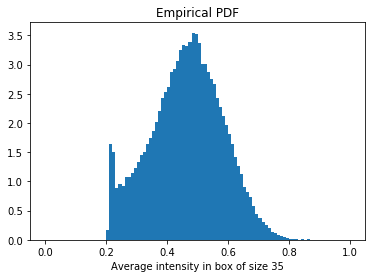

In [42]:
size=35
r = test_dataset.analyze_brightness_distribution(size=size,stride=3)
print(len(r))
print(r.shape)
a = plt.hist(r.view(-1), bins=100, range=(0,1),density=True)
plt.title("Empirical PDF")
plt.xlabel("Average intensity in box of size "+str(size))

tensor(3., device='cuda:0')


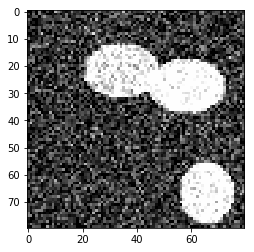

In [43]:
imgs_in, labels = train_dataset.load(128)
print(labels[0])
show_batch(imgs_in[:1])

Text(0.5,0,'pixel intensity')

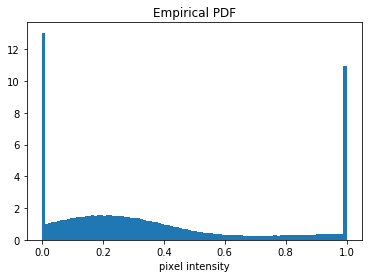

In [44]:
b = plt.hist(imgs_in.view(-1).cpu().numpy(), bins=100, range=(0,1),density=True)
plt.title("Empirical PDF")
plt.xlabel("pixel intensity")

## Set up the simulation

### Helper function for training and evaluation

In [45]:
def train_one_epoch(svi, dataset, epoch=None, batch_size=64, verbose=False):
    
    epoch_loss = 0.
    batch_iterator = dataset.generate_batch_iterator(batch_size)
    for i, indeces in enumerate(batch_iterator): #get the indeces

        # get the data from the indeces. Note that everything is already loaded into memory
        loss = svi.step(imgs=dataset[indeces][0], epoch=epoch)
        if(verbose):
            print("i= %3d train_loss=%.5f" %(i,loss))
        epoch_loss += loss

    return epoch_loss / ((i+1)*batch_size)

def evaluate_one_epoch(svi, dataset, epoch=None, batch_size=64, verbose=False):
    
    epoch_loss = 0.
    batch_iterator = dataset.generate_batch_iterator(batch_size)
    for i, indeces in enumerate(batch_iterator): #get the indeces

        # get the data from the indeces. Note that everything is already loaded into memory
        loss = svi.evaluate_loss(imgs=dataset[indeces][0],epoch=epoch)
        if(verbose):
            print("i= %3d test_loss=%.5f" %(i,loss))
        epoch_loss += loss

    return epoch_loss / ((i+1)*batch_size)

### Define optimizer and svi

In [46]:
# Set up pyro environment
pyro.clear_param_store()
pyro.set_rng_seed(0)

TEST_FREQUENCY = 5
WRITE_FREQUENCY = 5
smoke_test= False
if(smoke_test):
    pyro.enable_validation(True)
    pyro.distributions.enable_validation(True)
    NUM_EPOCHS = 21
else:
    pyro.enable_validation(False)
    pyro.distributions.enable_validation(False)
    NUM_EPOCHS = 101

## Train Loop

### Initialize stuff (always)

In [51]:
#Load if necessary
min_loss = 99999999
train_loss, test_loss = [], []
fg_mu, fg_sigma, bg_mu, bg_sigma = [], [], [], []
#save_model(vae,"/home/ldalessi/spacetx-research/incremental_steps/ARCHIVE/INIT/","vae_random_init_3")
#load_model(vae,"/home/ldalessi/spacetx-research/incremental_steps/ARCHIVE/INIT/","vae_random_init_3")

### Load pre-trained model (if necessary)

In [52]:
#write_dir = '/home/ldalessi/spacetx-research/incremental_steps/ARCHIVE/'
#load_model(vae,write_dir,"vae_Cauchy_free_param_100")
#test_loss = load_obj(write_dir,"test_loss_Cauchy_free_param_100")
#train_loss = load_obj(write_dir,"train_loss_Cauchy_free_param_100")

In [53]:
# the actual code 
write_dir = '/home/ldalessi/spacetx-research/incremental_steps/ARCHIVE/'
#descriptor      = "recover_results_disk"
#descriptor      = "DISK_standard_cauchy"
descriptor      = "DISK_unit_cauchy_v2"
#descriptor      = "MNIST_unit_cauchy"
#descriptor      = "mnist_bg"
name_vae        = "vae_"+descriptor+"_"
name_train_loss = "train_loss_"+descriptor+"_"
name_test_loss  = "test_loss_"+descriptor+"_"
name_params     = "params_"+descriptor

# batch size
batch_size = 128

# setup the optimizer
adam_args = {"lr": 1.0e-3}
optimizer = Adamax(adam_args)

svi = SVI(vae.model, config_enumerate(vae.guide, "parallel"), optimizer, loss=TraceEnum_ELBO(max_plate_nesting=2))
#svi = SVI(vae.model, vae.guide, optimizer, loss=TraceGraph_ELBO(max_plate_nesting=2))

#svi = SVI(vae.model, config_enumerate(vae.guide, "parallel"), optimizer, loss=JitTraceEnum_ELBO(max_plate_nesting=2))

# regularization parameters
vae.lambda_box_size = 0.0
vae.lambda_tot_var  = 0.0
vae.lambda_overlap  = 0.0
vae.LOSS_ZMASK = 0.1
vae.LOSS_ZMASK = 1.0

save_obj(params,write_dir,name_params)

In [64]:
# training loop
#for epoch in range(0,NUM_EPOCHS):
for epoch in range(101,2*101):
    vae.train()            
    loss = train_one_epoch(svi, train_dataset, epoch, batch_size, verbose=(epoch==0))
    train_loss.append(loss)
    try:
        fg_mu.append(pyro.param("fg_mu").item())
        bg_mu.append(pyro.param("bg_mu").item())
        fg_sigma.append(pyro.param("fg_sigma").item())
        bg_sigma.append(pyro.param("bg_sigma").item())
    except:
        pass
        
    
    print("[epoch %03d] train loss: %.4f" % (epoch, loss))
    
    if(epoch % TEST_FREQUENCY == 0):
        vae.eval()
        loss = evaluate_one_epoch(svi, test_dataset, epoch, batch_size, verbose=(epoch==0))
        test_loss.append(loss)
    
        if(test_loss[-1] < min_loss):
            print("[epoch %03d] test  loss: %.4f --New Record--" % (epoch, loss)) 
            min_loss = test_loss[-1]
            # Save if you got a record 
            save_model(vae,write_dir,name_vae+str(epoch))       
            save_obj(test_loss,write_dir,name_test_loss+str(epoch))
            save_obj(train_loss,write_dir,name_train_loss+str(epoch))
        else:
            print("[epoch %03d] test  loss: %.4f " % (epoch, loss))
            
    if(epoch % WRITE_FREQUENCY == 0):
        save_model(vae,write_dir,name_vae+str(epoch))       
        save_obj(test_loss,write_dir,name_test_loss+str(epoch))
        save_obj(train_loss,write_dir,name_train_loss+str(epoch))

[epoch 101] train loss: -5470.1892
[epoch 102] train loss: -5363.1733
[epoch 103] train loss: -5653.3059
[epoch 104] train loss: -5656.7392
[epoch 105] train loss: -5947.7701
[epoch 105] test  loss: -5820.3403 --New Record--
[epoch 106] train loss: -5924.6097
[epoch 107] train loss: -5883.1734
[epoch 108] train loss: -5974.8191
[epoch 109] train loss: -6050.5585
[epoch 110] train loss: -6077.8345
[epoch 110] test  loss: -5854.7593 --New Record--
[epoch 111] train loss: -6071.3345
[epoch 112] train loss: -6086.1558
[epoch 113] train loss: -6157.2211
[epoch 114] train loss: -6191.9835
[epoch 115] train loss: -6210.2762
[epoch 115] test  loss: -5831.6198 
[epoch 116] train loss: -6221.2682
[epoch 117] train loss: -6237.3172
[epoch 118] train loss: -6238.3260
[epoch 119] train loss: -6219.7842
[epoch 120] train loss: -6242.3040
[epoch 120] test  loss: -5959.6872 --New Record--
[epoch 121] train loss: -6235.0792
[epoch 122] train loss: -6350.2874
[epoch 123] train loss: -6323.0522
[epoch 12

# Check the results

In [65]:
print(bg_mu[-10:])
print(bg_sigma[-10:])
print(fg_mu[-10:])
print(fg_sigma[-10:])

[0.019902033731341362, 0.0196385495364666, 0.019381290301680565, 0.019129909574985504, 0.018881313502788544, 0.01863575540482998, 0.018393218517303467, 0.018153633922338486, 0.017916958779096603, 0.01768440194427967]
[0.20841796696186066, 0.20875518023967743, 0.2090824991464615, 0.20939750969409943, 0.20971156656742096, 0.2100246697664261, 0.21033543348312378, 0.21064288914203644, 0.2109474241733551, 0.21124663949012756]
[0.9921138286590576, 0.9922239780426025, 0.9923344254493713, 0.9924417734146118, 0.9925468564033508, 0.9926508069038391, 0.9927530288696289, 0.99285489320755, 0.9929556846618652, 0.9930561184883118]
[0.05925125628709793, 0.05890142172574997, 0.05853981524705887, 0.05818846821784973, 0.05782531201839447, 0.05745777487754822, 0.057103231549263, 0.0567513033747673, 0.056396082043647766, 0.05603581666946411]


### Load from file if necessary

In [66]:
write_dir = '/home/ldalessi/spacetx-research/incremental_steps/ARCHIVE/'

#descriptor      = "DISK_unit_cauchy"
#descriptor      = "no_unit_cauchy"
#descriptor      = "recover_results_disk"
#descriptor = "_original_"
#descriptor = "_incr1_poutine_mask_"
#descriptor = "_incr2_cauchy_to_normal_"
#descriptor = "_new_baseline_Cauchy_stable_LSE_"
#descriptor = "_new_baseline_Cauchy_NO_LSE_"
#descriptor = "_new_baseline_Normal_NO_LSE_"
#descriptor      ="mnist_bg"


#load_model(vae,write_dir,"vae_"+descriptor+"_200")
#test_loss = load_obj(write_dir,"test_loss_"+descriptor+"_200")
#train_loss = load_obj(write_dir,"train_loss_"+descriptor+"_200")
#name_vae = "vae_"+descriptor

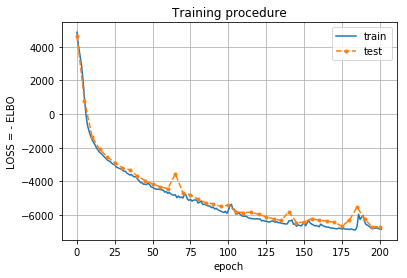

In [67]:
#plt.yscale('log')
y_shift=0
x_shift=0
plt.plot(np.arange(x_shift, x_shift+len(train_loss)), np.array(train_loss)+y_shift)
plt.plot(np.arange(x_shift, x_shift+len(train_loss), TEST_FREQUENCY), np.array(test_loss)+y_shift, '.--')
plt.xlabel('epoch')
plt.ylabel('LOSS = - ELBO')
plt.title('Training procedure')
#plt.ylim(ymax = 6000, ymin = 5000)
#plt.xlim(xmin = 20)
plt.grid(True)
plt.legend(['train', 'test'])
#plt.show()
from matplotlib import pyplot as plt
plt.savefig(write_dir+name_vae+'train.png')

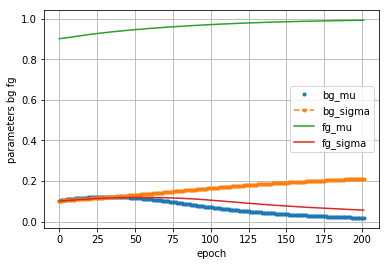

In [68]:
#plt.yscale('log')
plt.plot(bg_mu,'.')
plt.plot(bg_sigma,'.--')
plt.plot(fg_mu,'-')
plt.plot(fg_sigma,'-')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('parameters bg fg')
plt.legend(['bg_mu','bg_sigma','fg_mu','fg_sigma'])
plt.savefig(write_dir+name_vae+'parameters_fg_bg.png')

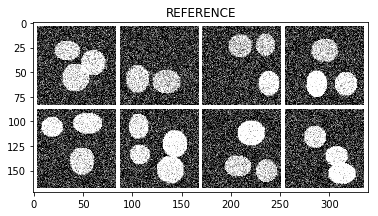

In [69]:
from matplotlib import pyplot as mp

reference_dir = '/home/ldalessi/DATA/REFERENCE/'
name='reference_mMNIST_v2'
#name='reference_disks_v3'
#name='reference_dapi'

# create image if necessary
reference_imgs, labels=test_dataset.load(8)
save_obj(reference_imgs ,reference_dir,name)

reference_imgs = load_obj(reference_dir,name)
show_batch(reference_imgs[:8],nrow=4,npadding=4,title="REFERENCE")
mp.savefig(write_dir+name+'.png')

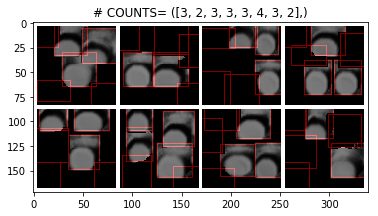

In [70]:
rec_img,z_where,putative_imgs,putative_masks,logp,reg = vae.reconstruct_img(reference_imgs,True)
counts = torch.sum(z_where.prob>0.5,dim=1).view(-1).cpu().numpy().tolist(),
b=show_batch(rec_img[:8],nrow=4,npadding=4,title="# COUNTS= "+str(counts))
mp.savefig(write_dir+name_vae+'rec_both.png')

[1.0, 1.0, 0.9996, 0.0, 0.0, 0.0]


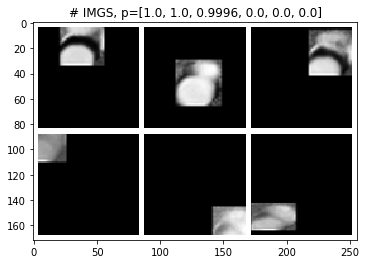

In [71]:
chosen=0
prob_tmp = np.round(z_where.prob[chosen].view(-1).cpu().numpy(),decimals=4)*10000
prob_title = (prob_tmp.astype(int)/10000).tolist()
print(prob_title)
b=show_batch(putative_imgs[chosen],nrow=3,npadding=4,title="# IMGS, p="+str(prob_title))
mp.savefig(write_dir+name_vae+'rec_imgs.png')

vae_DISK_unit_cauchy_v2_


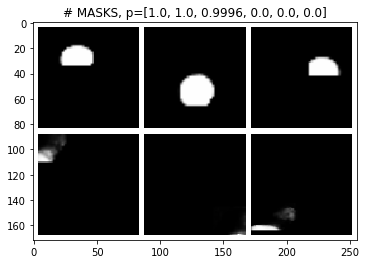

In [72]:
b=show_batch(putative_masks[chosen],nrow=3,npadding=4,title="# MASKS, p="+str(prob_title))
print(name_vae)
mp.savefig(write_dir+name_vae+'rec_masks.png')

In [ ]:
print("logp_off -------->",logp.logp_off[chosen].detach().cpu())
print("logp_on_cauchy -->",logp.logp_on_cauchy[chosen].detach().cpu())
print("logp_on_normal -->",logp.logp_on_normal[chosen].detach().cpu())
print("probability object",z_where.prob[chosen].detach().cpu().view(-1))

In [ ]:
off=logp.logp_off.view(-1).detach().cpu().numpy()
on_c=logp.logp_on_cauchy.view(-1).detach().cpu().numpy()
on_n=logp.logp_on_normal.view(-1).detach().cpu().numpy()
a1 = plt.hist([off,on_c,on_n],bins=20,histtype="bar",stacked=True)
plt.legend(["logp_off","logp_on_cauchy","logp_on_normal"], loc='upper right')
plt.title("Distribution of the 3 log_probs")
plt.xlabel("Log prob")

# MAKE MOVIE

In [ ]:
from matplotlib import pyplot as mp

list_of_pkl_files = list()
for file in os.listdir(write_dir):
    if file.endswith(".pkl") and file.startswith(name_vae):
        list_of_pkl_files.append(file.strip(".pkl"))
        
print(list_of_pkl_files)        
print(len(list_of_pkl_files))

In [ ]:
print(type(a))

In [ ]:
l=0
for epoch in range(0,515,5):
    if(epoch<10):
        label ="000"+str(epoch)
    elif(epoch<100):
        label = "00"+str(epoch)
    elif(epoch<1000):
        label = "0"+str(epoch)
    else:
        label = str(epoch)
    print(label)
    load_model(vae,write_dir,name_vae+str(epoch))
    rec_img,z_where,putative_masks,putative_imgs = vae.reconstruct_img(reference_imgs,True)
    a = show_batch(rec_img[:8],nrow=4,npadding=4,title="EPOCH = "+str(epoch))
    mp.savefig(write_dir+'rec'+name_vae+label+'.png')
    l += 1      

In [ ]:
import pyro.poutine as poutine

trace = poutine.trace(poutine.enum(vae.model, first_available_dim=-2)).get_trace()
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())


trace = poutine.trace(poutine.enum(vae.guide, first_available_dim=-2)).get_trace()
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())